## Installing Packages

In [ ]:
!pip install tensorflow opencv-python

In [ ]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import imghdr
import tensorflow as tf
from PIL import Image
import seaborn as sns
from collections import Counter
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import shutil
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras import layers, models, regularizers, optimizers
from tensorflow.keras.applications import VGG16, ResNet50V2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard, CSVLogger
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense, Activation, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.utils import plot_model

/tmp/ipython-input-362544649.py:7: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

##Download and unzip Dataset from Kaggle

In [ ]:
# Download and unzip Dataset from Kaggle
def download_dataset():
    dataset_dir = "/content/dataset"
    os.makedirs(dataset_dir, exist_ok=True)
    # Download only if dataset folders don't exist
    if not (os.path.exists("/content/dataset/drowsy") or os.path.exists("/content/dataset/nondrowsy")):
        print("Downloading dataset from Kaggle...")
        !kaggle datasets download -d atharvbheda/employee-drowsiness-detection
        print("Extracting dataset...")
        !unzip -q /content/employee-drowsiness-detection.zip -d /content/
        print("Dataset downloaded and extracted")
    else:
        print("Dataset already exists, skipping download")
    # Verify structure
    drowsy_dir = "/content/dataset/drowsy"
    nondrowsy_dir = "/content/dataset/nondrowsy"
    if os.path.exists(drowsy_dir) and os.path.exists(nondrowsy_dir):
        print(f"Dataset contains {len(os.listdir(drowsy_dir))} drowsy images and {len(os.listdir(nondrowsy_dir))} non-drowsy images")
    else:
        print("Warning: Expected directory structure not found")

download_dataset()

Dataset URL: https://www.kaggle.com/datasets/atharvbheda/employee-drowsiness-detection
License(s): unknown
 99% 2.35G/2.38G [00:20<00:00, 105MB/s] 
100% 2.38G/2.38G [00:21<00:00, 122MB/s]
Extracting dataset...
Dataset downloaded and extracted
Dataset contains 6019 drowsy images and 6051 non-drowsy images


##Create Directory Structure

In [ ]:
# Create directory structure for final split
def create_directory_structure(base_dir):
    os.makedirs(base_dir, exist_ok=True)
    for split in ['train', 'val', 'test']:
        for cls in ['drowsy', 'nondrowsy']:
            os.makedirs(os.path.join(base_dir, split, cls), exist_ok=True)
    print(f"Created directory structure at {base_dir}")

base_dir = '/content/Drowsiness_Detection_Demo/final_split'
create_directory_structure(base_dir)

Created directory structure at /content/Drowsiness_Detection_Demo/final_split


##Collect Files and Labels

In [ ]:
# Collect file paths and labels from dataset
def collect_files(data_dir):
    file_paths, labels, class_counts = [], [], {}
    for class_name in ['drowsy', 'nondrowsy']:
        class_dir = os.path.join(data_dir, class_name)
        if not os.path.exists(class_dir):
            print(f"Warning: Class directory {class_dir} not found")
            continue
        class_files = [os.path.join(class_dir, file) for file in os.listdir(class_dir)
                       if file.lower().endswith(('.png', '.jpg', '.jpeg'))]
        file_paths.extend(class_files)
        class_label = 1 if class_name == 'drowsy' else 0
        labels.extend([class_label] * len(class_files))
        class_counts[class_name] = len(class_files)
    print(f"Found {len(file_paths)} images; Class distribution: {class_counts}")
    return file_paths, labels

original_data_dir = '/content/dataset'
file_paths, labels = collect_files(original_data_dir)

Found 12070 images; Class distribution: {'drowsy': 6019, 'nondrowsy': 6051}


##Split Data into Train, Validation, and Test Sets

In [ ]:
def split_data(file_paths, labels):
    train_files, temp_files, train_labels, temp_labels = train_test_split(
        file_paths, labels, test_size=0.3, stratify=labels, random_state=42)
    val_files, test_files, val_labels, test_labels = train_test_split(
        temp_files, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42)
    print("\nTrain-Val-Test Split:")
    print(f"Train: {len(train_files)} images - {Counter(train_labels)}")
    print(f"Validation: {len(val_files)} images - {Counter(val_labels)}")
    print(f"Test: {len(test_files)} images - {Counter(test_labels)}")
    return train_files, val_files, test_files, train_labels, val_labels, test_labels

train_files, val_files, test_files, train_labels, val_labels, test_labels = split_data(file_paths, labels)


Train-Val-Test Split:
Train: 8449 images - Counter({0: 4236, 1: 4213})
Validation: 1810 images - Counter({0: 907, 1: 903})
Test: 1811 images - Counter({0: 908, 1: 903})


##Copy Files to Train/Val/Test Directories

In [ ]:
def copy_files_with_validation(files, labels, split_folder, base_dir):
    error_count = success_count = 0
    for file_path, label in tqdm(list(zip(files, labels)), desc=f"Copying {split_folder}", total=len(files)):
        if not os.path.isfile(file_path):
            print(f"Missing file: {file_path}")
            error_count += 1
            continue

        class_name = 'drowsy' if label == 1 else 'nondrowsy'
        dest_path = os.path.join(base_dir, split_folder, class_name, os.path.basename(file_path))
        shutil.copy2(file_path, dest_path)
        success_count += 1
    print(f"Copied {success_count} files to {split_folder}, {error_count} errors")
    return success_count, error_count

for split, files, lab in zip(['train', 'val', 'test'],
                             [train_files, val_files, test_files],
                             [train_labels, val_labels, test_labels]):
    copy_files_with_validation(files, lab, split, base_dir)

# Copy files to respective directories
# Note: This may take some time depending on the dataset size
copy_files_with_validation(train_files, train_labels, 'train', base_dir)
copy_files_with_validation(val_files, val_labels, 'val', base_dir)
copy_files_with_validation(test_files, test_labels, 'test', base_dir)


Copying train: 100%|██████████| 8449/8449 [00:09<00:00, 867.41it/s] 


Copied 8449 files to train, 0 errors


Copying val: 100%|██████████| 1810/1810 [00:01<00:00, 908.40it/s]


Copied 1810 files to val, 0 errors


Copying test: 100%|██████████| 1811/1811 [00:04<00:00, 435.81it/s]


Copied 1811 files to test, 0 errors


Copying train: 100%|██████████| 8449/8449 [00:20<00:00, 415.28it/s]


Copied 8449 files to train, 0 errors


Copying val: 100%|██████████| 1810/1810 [00:02<00:00, 654.29it/s]


Copied 1810 files to val, 0 errors


Copying test: 100%|██████████| 1811/1811 [00:02<00:00, 706.66it/s]

Copied 1811 files to test, 0 errors


(1811, 0)

##Verify Dataset Splits

In [ ]:
def verify_splits(base_dir):
    result = {}
    for split in ['train', 'val', 'test']:
        counts = {}
        for cls in ['drowsy', 'nondrowsy']:
            path = os.path.join(base_dir, split, cls)
            if os.path.exists(path):
                counts[cls] = len([f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))])
        result[split] = counts
        total = sum(counts.values())
        print(f"{split}: {total} images - {counts}")
    return result

verify_splits(base_dir)

train: 8449 images - {'drowsy': 4213, 'nondrowsy': 4236}
val: 1810 images - {'drowsy': 903, 'nondrowsy': 907}
test: 1811 images - {'drowsy': 903, 'nondrowsy': 908}


{'train': {'drowsy': 4213, 'nondrowsy': 4236},
 'val': {'drowsy': 903, 'nondrowsy': 907},
 'test': {'drowsy': 903, 'nondrowsy': 908}}

##Data Augmentation

In [ ]:
def create_augmentation_model():
    return tf.keras.Sequential([
        tf.keras.layers.RandomFlip("horizontal", input_shape=(224, 224, 3)),
        tf.keras.layers.RandomRotation(0.05),
        tf.keras.layers.RandomZoom(0.1, fill_mode='reflect'),
        tf.keras.layers.RandomContrast(0.1),
        tf.keras.layers.RandomBrightness(0.1),
        tf.keras.layers.GaussianNoise(0.02)
    ])
data_augmentation = create_augmentation_model()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


##Image Processing Function

In [ ]:
def process_path(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    label = tf.cast(tf.equal(parts[-2], "drowsy"), tf.int32)
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (224, 224))
    return img, label

##Build TensorFlow Datasets

In [ ]:
# Build TensorFlow datasets from directory
def build_tf_datasets(base_dir, batch_size=64):
    AUTOTUNE = tf.data.AUTOTUNE
    def get_dataset(directory, shuffle=False):
        return tf.keras.utils.image_dataset_from_directory(
            directory, labels='inferred', label_mode='binary',
            class_names=['nondrowsy', 'drowsy'], image_size=(224, 224),
            batch_size=batch_size, shuffle=shuffle
        )
    train_ds = get_dataset(os.path.join(base_dir, 'train'), shuffle=True)
    val_ds = get_dataset(os.path.join(base_dir, 'val'))
    test_ds = get_dataset(os.path.join(base_dir, 'test'))
    train_ds = train_ds.cache().prefetch(AUTOTUNE)
    val_ds = val_ds.cache().prefetch(AUTOTUNE)
    test_ds = test_ds.cache().prefetch(AUTOTUNE)
    normalization_layer = tf.keras.layers.Rescaling(1./255.0)
    train_ds = train_ds.map(lambda x, y: (normalization_layer(data_augmentation(x, training=True)), y), num_parallel_calls=AUTOTUNE)
    val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)
    test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)
    print(f"Created TensorFlow datasets with batch size {batch_size}")
    return train_ds, val_ds, test_ds

batch_size = 64
train_ds, val_ds, test_ds = build_tf_datasets(base_dir, batch_size)

Found 8449 files belonging to 2 classes.
Found 1810 files belonging to 2 classes.
Found 1811 files belonging to 2 classes.
Created TensorFlow datasets with batch size 64


##Visualize Dataset Samples

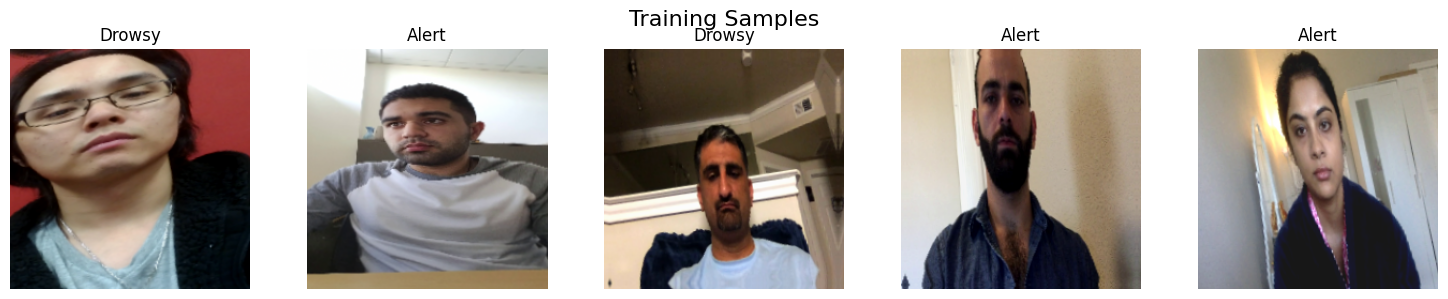

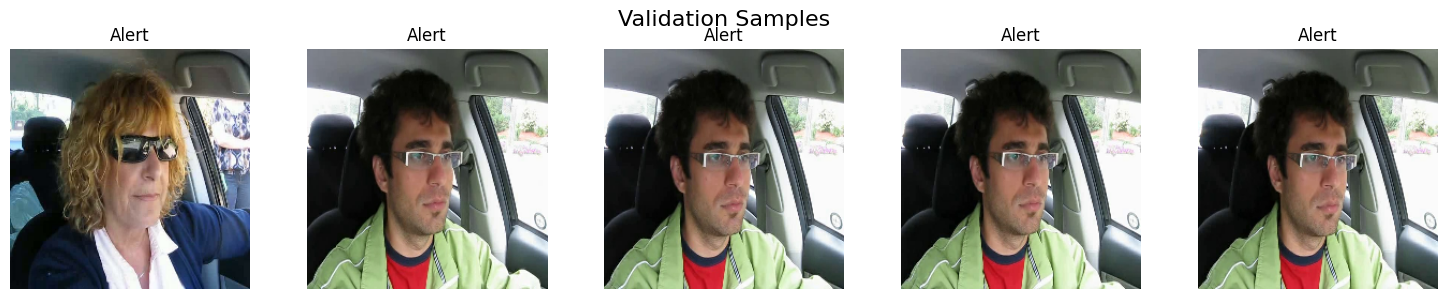

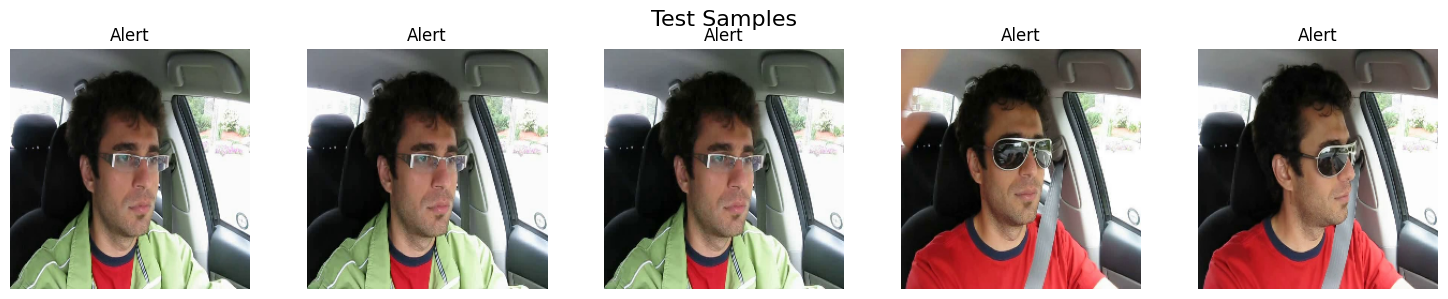

In [ ]:
def visualize_dataset_samples(dataset, title, num_samples=5):
    for images, labels in dataset.take(1):
        images, labels = images[:num_samples], labels[:num_samples]
        plt.figure(figsize=(15, 3))
        plt.suptitle(title, fontsize=16)
        for i in range(num_samples):
            plt.subplot(1, num_samples, i + 1)
            img = (images[i].numpy() + 1) * 127.5  # reverse normalization
            img = np.clip(img, 0, 255).astype(np.uint8)
            plt.imshow(img)
            plt.title("Drowsy" if labels[i] else "Alert")
            plt.axis('off')
        plt.tight_layout(); plt.subplots_adjust(top=0.85); plt.show()

visualize_dataset_samples(train_ds, "Training Samples")
visualize_dataset_samples(val_ds, "Validation Samples")
visualize_dataset_samples(test_ds, "Test Samples")

##Visualize Augmentations

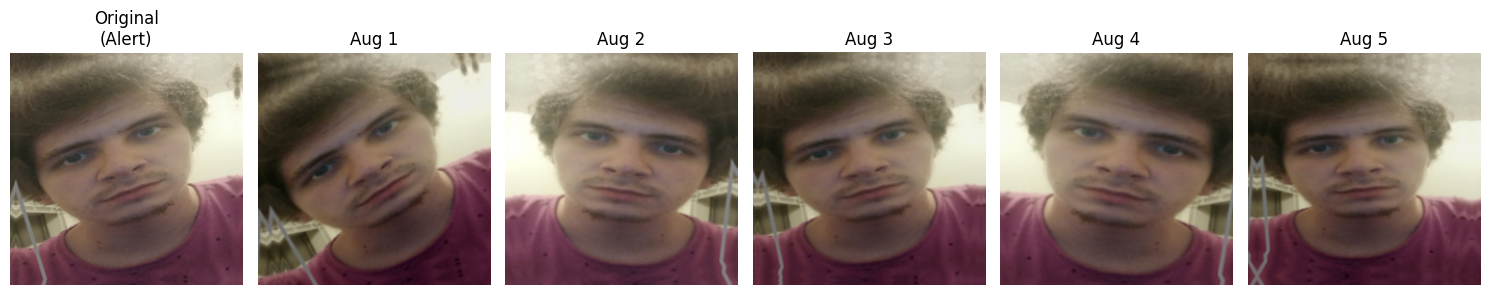

In [ ]:
# Visualize augmentations for one sample
def plot_augmentations(dataset, num_augmentations=5):
    data_aug = create_augmentation_model()
    for images, labels in dataset.unbatch().take(1):
        original_img = (images.numpy() + 1) * 127.5
        original_img = np.clip(original_img, 0, 255).astype(np.uint8)
        label_str = "Drowsy" if labels.numpy() == 1 else "Alert"
        plt.figure(figsize=(15, 4))
        plt.subplot(1, num_augmentations + 1, 1)
        plt.imshow(original_img); plt.title(f"Original\n({label_str})"); plt.axis("off")
        for i in range(num_augmentations):
            plt.subplot(1, num_augmentations + 1, i + 2)
            aug_img = data_aug(tf.expand_dims(tf.cast(original_img, tf.float32), 0), training=True)
            plt.imshow(aug_img[0].numpy().astype("uint8")); plt.title(f"Aug {i+1}"); plt.axis("off")
        plt.tight_layout(); plt.show()

plot_augmentations(train_ds)

##Final Check

In [ ]:
# Data pipeline summary
print("\n===== Data Pipeline Summary =====")
print(f"Dataset location: {original_data_dir}\nProcessed data location: {base_dir}\nBatch size: {batch_size}")
train_batches = tf.data.experimental.cardinality(train_ds).numpy()
val_batches = tf.data.experimental.cardinality(val_ds).numpy()
test_batches = tf.data.experimental.cardinality(test_ds).numpy()
print(f"Training: {train_batches} batches\nValidation: {val_batches} batches\nTest: {test_batches} batches")
print("\nData pipeline setup complete! The datasets (train_ds, val_ds, test_ds) are ready for model training.")


===== Data Pipeline Summary =====
Dataset location: /content/dataset
Processed data location: /content/Drowsiness_Detection_Demo/final_split
Batch size: 64
Training: 133 batches
Validation: 29 batches
Test: 29 batches

Data pipeline setup complete! The datasets (train_ds, val_ds, test_ds) are ready for model training.


##Save tf dataset

In [ ]:
# Save TensorFlow datasets to disk for future use
def save_tf_datasets(train_ds, val_ds, test_ds, base_dir):
    save_dir = os.path.join(base_dir, 'saved_datasets')
    os.makedirs(save_dir, exist_ok=True)
    print("Saving datasets to disk...")
    tf.data.Dataset.save(train_ds, os.path.join(save_dir, 'train_ds'))
    tf.data.Dataset.save(val_ds, os.path.join(save_dir, 'val_ds'))
    tf.data.Dataset.save(test_ds, os.path.join(save_dir, 'test_ds'))
    print("Datasets saved successfully")

save_tf_datasets(train_ds, val_ds, test_ds, base_dir)

Saving datasets to disk...
Datasets saved successfully


##Copy tf datasets to drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Copy saved datasets to Google Drive
drive_save_path = '/content/drive/MyDrive/tf_datasets/saved_datasets'
local_save_path = os.path.join(base_dir, 'saved_datasets')

print(f"Copying datasets from {local_save_path} to {drive_save_path}...")

# Ensure the destination directory exists in Google Drive
os.makedirs(drive_save_path, exist_ok=True)

# Copy the directory
!cp -r "{local_save_path}" "{drive_save_path}/.."

print("Datasets copied to Google Drive successfully!")

##Load Dataset from Drive

In [ ]:
os.makedirs("/content/Drowsiness_Detection", exist_ok=True)
!cp -r /content/drive/MyDrive/tf_datasets/saved_datasets /content/Drowsiness_Detection/

In [ ]:
# Load datasets from disk
load_dir = "/content/Drowsiness_Detection/saved_datasets"
train_ds = tf.data.Dataset.load(f"{load_dir}/train_ds")
val_ds = tf.data.Dataset.load(f"{load_dir}/val_ds")
test_ds = tf.data.Dataset.load(f"{load_dir}/test_ds")
print("Datasets loaded successfully!")

Datasets loaded successfully!


##Visualise Loaded Datasets

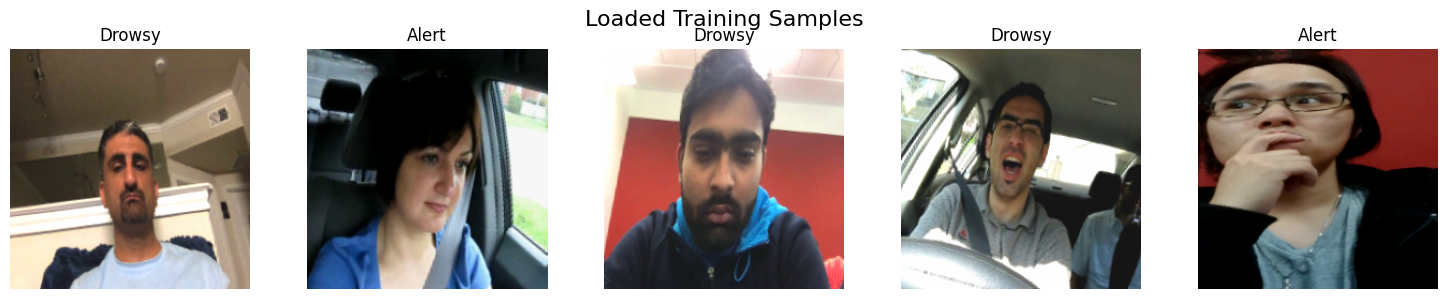

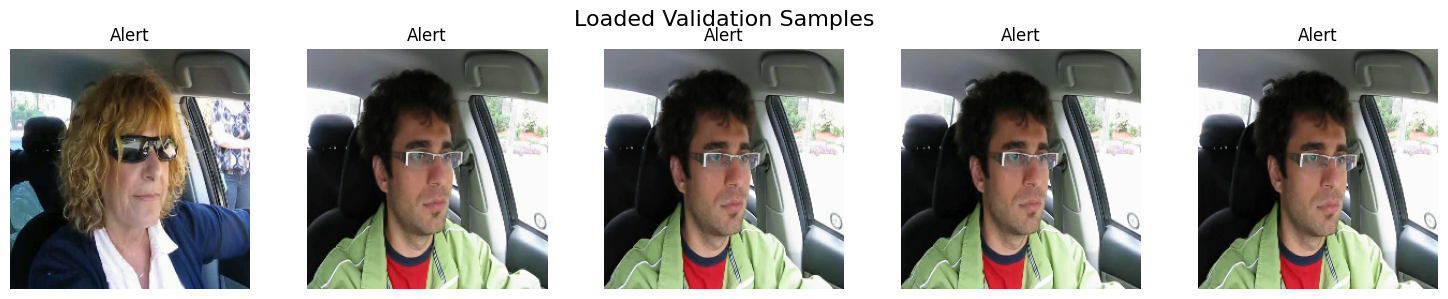

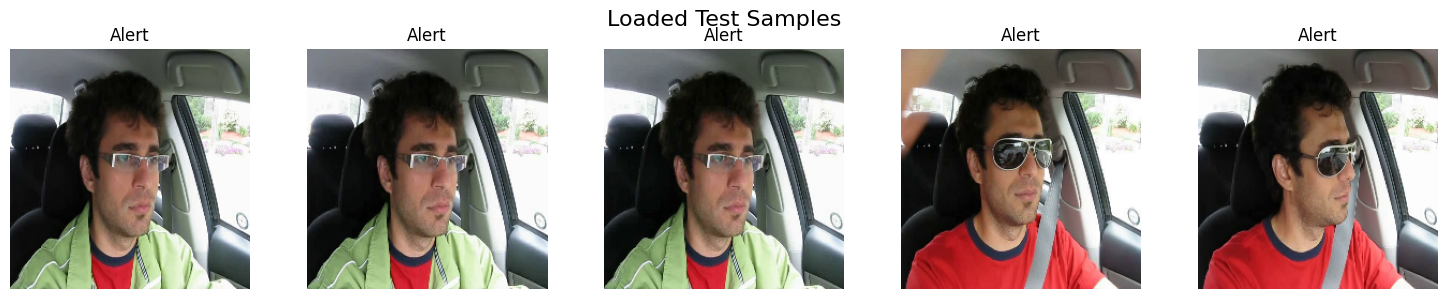

In [ ]:
# Visualize loaded datasets (reuse visualize_dataset_samples)
def visualize_dataset_samples(dataset, title, num_samples=5):
    for images, labels in dataset.take(1):
        images, labels = images[:num_samples], labels[:num_samples]
        plt.figure(figsize=(15, 3))
        plt.suptitle(title, fontsize=16)
        for i in range(num_samples):
            plt.subplot(1, num_samples, i + 1)
            img = (images[i].numpy() + 1) * 127.5  # reverse normalization
            img = np.clip(img, 0, 255).astype(np.uint8)
            plt.imshow(img)
            plt.title("Drowsy" if labels[i] else "Alert")
            plt.axis('off')
        plt.tight_layout(); plt.subplots_adjust(top=0.85); plt.show()

visualize_dataset_samples(train_ds, "Loaded Training Samples")
visualize_dataset_samples(val_ds, "Loaded Validation Samples")
visualize_dataset_samples(test_ds, "Loaded Test Samples")

In [ ]:
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input

train_ds = train_ds.map(lambda x, y: (preprocess_input(x), y))
val_ds = val_ds.map(lambda x, y: (preprocess_input(x), y))
test_ds = test_ds.map(lambda x, y: (preprocess_input(x), y))


#Build Model

In [ ]:
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Build EfficientNetV2B0 base model
base_model = EfficientNetV2B0(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)
base_model.trainable = False  # Freeze base layers initially

# Add classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
output = Dense(2, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# Compile
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          0 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ normalization[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │      4,608 │ stem_activation[… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 112, 112,  │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 112, 112,  │          0 │ block1a_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 56, 56,    │      9,216 │ block1a_project_… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 56, 56,    │        256 │ block2a_expand_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, 56, 56,    │          0 │ block2a_expand_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_co… │ (None, 56, 56,    │      2,048 │ block2a_expand_a… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_bn  │ (None, 56, 56,    │        128 │ block2a_project_… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_conv │ (None, 56, 56,    │     36,864 │ block2a_project_… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_bn   │ (None, 56, 56,    │        512 │ block2b_expand_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_act… │ (None, 56, 56,    │          0 │ block2b_expand_b

 Total params: 6,083,538 (23.21 MB)

 Trainable params: 164,226 (641.51 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

checkpoint = ModelCheckpoint('efficientnetv2_best.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
earlystop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, verbose=1)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[checkpoint, earlystop, lr_reduce]
)


Epoch 1/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.4913 - loss: 0.7158
Epoch 1: val_accuracy improved from -inf to 0.50221, saving model to efficientnetv2_best.h5


133/133 ━━━━━━━━━━━━━━━━━━━━ 104s 540ms/step - accuracy: 0.4913 - loss: 0.7157 - val_accuracy: 0.5022 - val_loss: 0.6926 - learning_rate: 1.0000e-04
Epoch 2/20
132/133 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - accuracy: 0.4905 - loss: 0.7021
Epoch 2: val_accuracy improved from 0.50221 to 0.50829, saving model to efficientnetv2_best.h5


133/133 ━━━━━━━━━━━━━━━━━━━━ 41s 309ms/step - accuracy: 0.4905 - loss: 0.7020 - val_accuracy: 0.5083 - val_loss: 0.6914 - learning_rate: 1.0000e-04
Epoch 3/20
132/133 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - accuracy: 0.5002 - loss: 0.6987
Epoch 3: val_accuracy did not improve from 0.50829
133/133 ━━━━━━━━━━━━━━━━━━━━ 40s 305ms/step - accuracy: 0.5003 - loss: 0.6986 - val_accuracy: 0.5077 - val_loss: 0.6914 - learning_rate: 1.0000e-04
Epoch 4/20
132/133 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - accuracy: 0.5100 - loss: 0.6971
Epoch 4: val_accuracy improved from 0.50829 to 0.59503, saving model to efficientnetv2_best.h5


133/133 ━━━━━━━━━━━━━━━━━━━━ 41s 306ms/step - accuracy: 0.5099 - loss: 0.6971 - val_accuracy: 0.5950 - val_loss: 0.6904 - learning_rate: 1.0000e-04
Epoch 5/20
132/133 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - accuracy: 0.5126 - loss: 0.6955
Epoch 5: val_accuracy did not improve from 0.59503
133/133 ━━━━━━━━━━━━━━━━━━━━ 44s 334ms/step - accuracy: 0.5126 - loss: 0.6955 - val_accuracy: 0.5475 - val_loss: 0.6905 - learning_rate: 1.0000e-04
Epoch 6/20
132/133 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - accuracy: 0.5063 - loss: 0.6951
Epoch 6: val_accuracy did not improve from 0.59503
133/133 ━━━━━━━━━━━━━━━━━━━━ 41s 306ms/step - accuracy: 0.5064 - loss: 0.6951 - val_accuracy: 0.5453 - val_loss: 0.6906 - learning_rate: 1.0000e-04
Epoch 7/20
132/133 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.5141 - loss: 0.6951
Epoch 7: val_accuracy did not improve from 0.59503

Epoch 7: ReduceLROnPlateau reducing learning rate to 2.9999999242136255e-05.
133/133 ━━━━━━━━━━━━━━━━━━━━ 42s 314ms/step - accuracy: 0.514

#Evaluation

2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 155ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
2/2 ━━━━

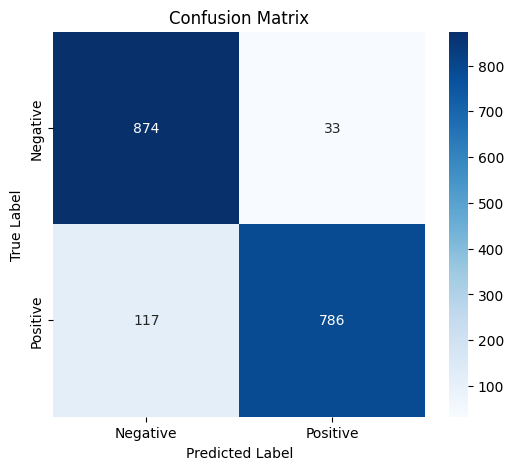

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

def plot_confusion_matrix(model, dataset, class_names=['Negative', 'Positive']):
    """
    Generate and plot a confusion matrix for a trained model.

    Parameters:
    - model: Trained Keras model
    - dataset: tf.data.Dataset (validation or test dataset)
    - class_names: List of class names for display (default: ['Negative', 'Positive'])

    Returns:
    - Confusion matrix plot
    - Prints classification report
    """
    # Extract ground truth labels and predictions
    y_true = []
    y_pred = []

    for images, labels in dataset:
        preds = model.predict(images)
        y_true.extend(labels.numpy())  # Convert tensors to numpy arrays
        y_pred.extend(preds.flatten())  # Convert predictions to 1D array

    # Convert predicted probabilities to binary class labels
    y_pred = np.array(y_pred) > 0.5  # Assuming sigmoid activation (binary classification)

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Print classification report
    print("Classification Report:\n", classification_report(y_true, y_pred, target_names=class_names))

    # Plot confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(model, val_ds)

##Load Model and Predict on Immage

In [ ]:
from tensorflow import keras

# Load the model
model = keras.models.load_model('/content/best_model_finetune.keras')

# Verify the loaded model (optional)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50v2_backbone (Functional)     │ (None, 7, 7, 2048)          │      23,564,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 55,658,629 (212.32 MB)

 Trainable params: 15,775,745 (60.18 MB)

 Non-trainable params: 8,331,392 (31.78 MB)

 Optimizer params: 31,551,492 (120.36 MB)

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

def predict_drowsiness(model, img_path, class_names=['Non-Drowsy', 'Drowsy']):
    """
    Predicts drowsiness on a new image using the trained model.

    Parameters:
    - model: Trained Keras model
    - img_path: Path to the image file
    - class_names: List of class labels (default: ['Non-Drowsy', 'Drowsy'])

    Returns:
    - Predicted class label and probability
    - Displays the image with prediction
    """
    # Load and preprocess image
    img = image.load_img(img_path, target_size=(224, 224))  # Resize to match model input
    img_array = image.img_to_array(img)  # Convert to array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize (assuming your training data is normalized)

    # Make prediction
    prediction = model.predict(img_array)[0][0]  # Get probability score
    predicted_class = class_names[int(prediction > 0.5)]  # Convert to class label

    # Display the image with prediction
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Predicted: {predicted_class} ({prediction:.2f})')
    plt.show()

    return predicted_class, prediction